In [1]:
import pandas
pandas.set_option("display.max_rows", 50, "display.max_columns", 50)

import pygsheets
import numpy
import scipy

import matplotlib.pyplot as mp
import matplotlib.cm

In [2]:
# solarized colors
solar_base03    = '#002b36' # darkest gray
solar_base02    = '#073642'
solar_base01    = '#586e75'
solar_base00    = '#657b83'
solar_base0     = '#839496' # light gray
solar_base1     = '#93a1a1' # lightest gray
solar_base2     = '#eee8d5' # dark white
solar_base3     = '#fdf6e3' # light white
solar_yellow    = '#b58900'
solar_orange    = '#cb4b16'
solar_red       = '#dc322f'
solar_magenta   = '#d33682'
solar_violet    = '#6c71c4'
solar_blue      = '#268bd2'
solar_cyan      = '#2aa198'
solar_green     = '#859900'

import Pipelines_Current dataset

# import data

In [64]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet[1].get_as_df(encoding='latin1')
oil_pipes = spreadsheet[2].get_as_df(encoding='latin1')
#owners = spreadsheet[2].get_as_df()

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)

pipes_df = pipes_df[pipes_df['Status']!='N/A']

#pipe = spreadsheet[1].get_as_df()
#pipe = pipe.drop('WKTFormat', axis=1)

#get other relevant sheets
country_ratios = spreadsheet[5].get_as_df(encoding='latin1')
owners_df = spreadsheet[3].get_as_df(encoding='latin1')
owners_df.set_index('ProjectID', inplace=True)

### replace "--" with NaN

In [65]:
# replace -- entries with NaN
pipes_df_orig_copy = pipes_df.copy() # for extending into further years?
pipes_df = pipes_df.replace('--', numpy.nan)
#pipes_df['StartYearLast'].replace('', numpy.nan, inplace=True)

In [66]:
country_ratios['StartYearLatest'].replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [67]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios['Country'])))
region_list = sorted(list(set(country_ratios['Region'])))

In [68]:
country_ratios_gas = country_ratios[country_ratios['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_status = country_ratios_gas[country_ratios_gas['Status']==status]
    km_by_country_df[status] = country_ratios_gas_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_status = country_ratios_gas[country_ratios_gas['Status']==status]
    km_by_region_df[status] = country_ratios_gas_status.groupby('Region')['MergedKmByCountry'].sum()

# fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [69]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [70]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

## add Total row to km by country/region

In [71]:
km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,32425.36,26347.70,58773.06,1043.97,1044.13,92155.49,0.0,0.0,41.00
South Asia,4091.03,17859.66,21950.69,6017.71,6143.81,20585.75,0.0,0.0,35.00
Europe,14789.44,5387.64,20177.08,1273.96,15805.31,116510.27,0.0,0.0,1079.95
Sub-Saharan Africa,14048.02,5517.86,19565.88,1633.15,288.21,11753.94,0.0,0.0,0.00
Eurasia,11584.11,5088.02,16672.13,2671.80,6644.05,139772.95,0.0,193.0,2551.86
North America,8914.74,7707.02,16621.76,9611.09,12878.00,418274.98,516.0,0.0,0.00
Latin America and the Caribbean,12236.73,541.00,12777.73,3453.02,22161.34,43327.48,0.0,224.0,0.00
Australia and New Zealand,9161.09,580.00,9741.09,1102.00,6161.88,27316.05,0.0,0.0,0.00
Middle East and North Africa,4389.86,5014.25,9404.11,7178.74,3704.49,29580.86,1200.0,0.0,39.28
SE Asia,7056.44,1121.00,8177.44,2630.43,3013.62,15839.92,0.0,0.0,0.00


# numbers of pipes finished in a given year

In [72]:
pipes_started = pipes_df.copy()
pipes_started['StartYearLatest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Gas')]
pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [73]:
pipes_indev = pipes_df.copy()
pipes_indev = pipes_indev[pipes_indev['Fuel']=='Gas']
pipes_indev = pipes_indev.groupby('Status')['LengthMergedKm'].sum()

Text(0.5, 1.0, 'gas pipelines (km) by start year')

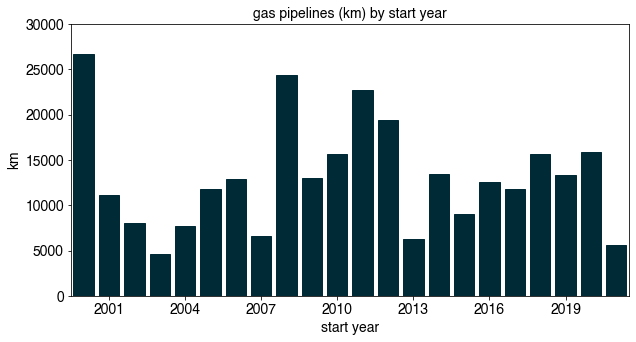

In [74]:
font_size = 14

fig = mp.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum.index.values[:-1], pipes_started_sum.values[:-1],
       color=solar_base03, edgecolor=solar_base03)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(1999.5, 2021.5)
ax.set_ylim(0, 30000)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax.set_title('gas pipelines (km) by start year', size=font_size)

Text(0.5, 1.0, 'gas pipelines (km) by start year')

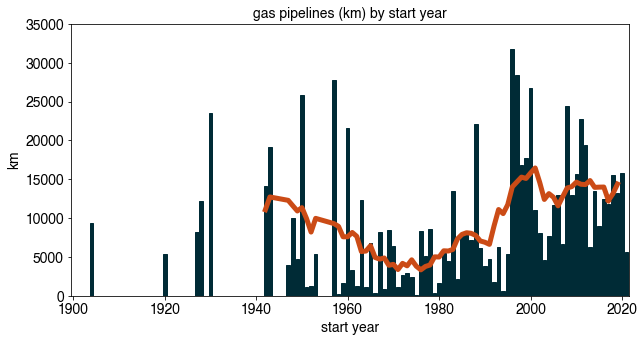

In [75]:
font_size = 14

fig = mp.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum.index.values[:-1], pipes_started_sum.values[:-1],
       color=solar_base03, edgecolor=solar_base03)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(1899.5, 2021.5)
ax.set_ylim(0, 35000)

ax.plot(pipes_started_sum.index.values[:-6], 
        pipes_started_sum.rolling(10, center=True).mean().values[:-6],
       c=solar_orange, lw=5)

ax.plot(pipes_started_sum.index.values[-7:-1], 
        pipes_started_sum.rolling(10, center=True, win_type='exponential').mean().values[-7:-1],
       c=solar_orange, lw=5)

# ax.plot(pipes_started_sum.index.values[-7:-3], pipes_started_sum.values[-7:-3],
#        c=solar_orange, lw=5)

ax.set_title('gas pipelines (km) by start year', size=font_size)

Text(0.5, 1.0, 'gas pipelines (km) by start year')

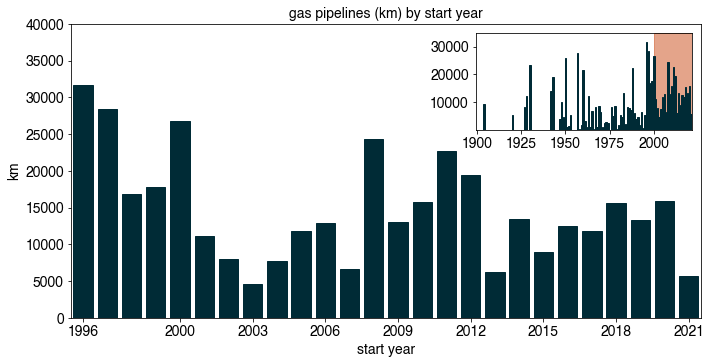

In [76]:
font_size = 14

fig = mp.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum.index.values[:-1], pipes_started_sum.values[:-1],
       color=solar_base03, edgecolor=solar_base03)
ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(1995.5, 2021.5)
ax.set_ylim(0, 40000)
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.set_xticks([1996]+list(range(2000,2022,3)))

fig.tight_layout()
ax_pos = ax.get_position()
ax2 = fig.add_axes([0.666,0.66,0.3,0.27])

ax2.bar(pipes_started_sum.index.values[:-1], pipes_started_sum.values[:-1],
       color=solar_base03, edgecolor=solar_base03)
ax2.tick_params(labelsize=font_size)
#ax2.set_xlabel('start year', size=font_size)
#ax2.set_ylabel('km', size=font_size)

ax2.axvspan(2000,2021.5, alpha=0.5, color=solar_orange, zorder=0)

ax2.set_xlim(1899.5, 2021.5)
ax2.set_ylim(0, 35000)
ax2.set_yticks([10000,20000,30000])

ax.set_title('gas pipelines (km) by start year', size=font_size)

## 2016 onward plots

Text(0.5, 1.0, 'gas pipelines (km) by start year')

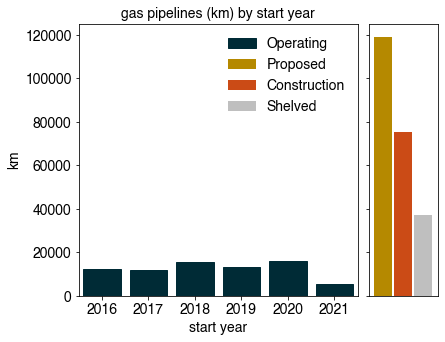

In [77]:
font_size = 14

ytop = 125000

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[:-1], pipes_started_sum.values[:-1],
       color=solar_base03, edgecolor=solar_base03, label='Operating')
ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.5, 2021.5)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))



ax2 = fig.add_axes([axpos.x1+0.03, axpos.y0, 0.25*(axpos.x1-axpos.x0), axpos.y1-axpos.y0])
ax2.set_ylim(0, ytop)
ax2.set_xlim(0.25,3.75)
ax2pos = ax2.get_position()

xvals = [1,2,3]
colors = [solar_yellow, solar_orange, '0.75']
status = ['Proposed','Construction', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev[s],
             width=0.9, color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)


ax.set_title('gas pipelines (km) by start year', size=font_size)

## trend line calculation?

## extend into future

In [78]:
pipes_indev_future = pipes_df.copy()[pipes_df['Fuel']=='Gas']
pipes_indev_future['StartYearLatest'].replace(numpy.nan,'') # originally '--' became NaN

# construction
pipes_indev_future_const = pipes_indev_future.copy()[pipes_indev_future['Status'].isin(['Construction'])]
pipes_indev_future_const['StartYearLatest'] = pipes_indev_future_const['StartYearLatest'].replace(numpy.nan,'')
pipes_indev_future_const_sum = pipes_indev_future_const.groupby('StartYearLatest')['LengthMergedKm'].sum()

# proposed
pipes_indev_future_prop = pipes_indev_future.copy()[pipes_indev_future['Status'].isin(['Proposed'])]
pipes_indev_future_prop['StartYearLatest'] = pipes_indev_future_prop['StartYearLatest'].replace(numpy.nan,'')
pipes_indev_future_prop_sum = pipes_indev_future_prop.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [79]:
year_list_past_future = list(set(list(pipes_indev_future_const_sum.index)+
                                 list(pipes_indev_future_prop_sum.index)+
                                 list(pipes_started_sum.index)))
# remove the empty string
#year_list_past_future.remove('')

past_future_sums_df = pandas.DataFrame(index=year_list_past_future, columns=['Operating','Construction','Proposed'])

past_future_sums_df['Operating'] = pipes_started_sum
past_future_sums_df['Construction'] = pipes_indev_future_const_sum
past_future_sums_df['Proposed'] = pipes_indev_future_prop_sum
#past_future_sums_df.replace(numpy.nan, 0, inplace=True)

# distribute the remainder over the next N years

nyears = 5
construction_remainder = past_future_sums_df.loc['']['Construction']/nyears
proposed_remainder = past_future_sums_df.loc['']['Proposed']/nyears

# add to past_future_sums_df
past_future_sums_df['Construction Remainder'] = numpy.nan
past_future_sums_df['Proposed Remainder'] = numpy.nan

past_future_sums_df['Construction Remainder'].loc[list(range(2022,2022+nyears))] = construction_remainder/nyears
past_future_sums_df['Proposed Remainder'].loc[list(range(2022,2022+nyears))] = proposed_remainder/nyears

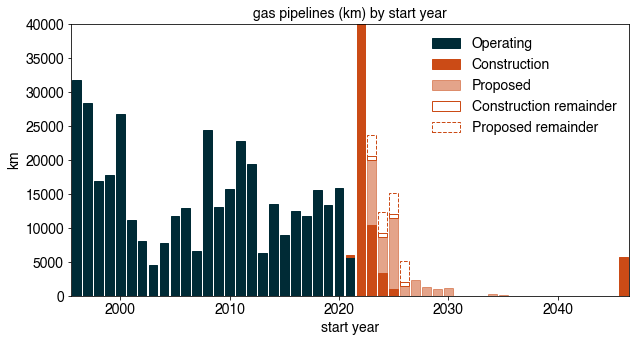

In [80]:
font_size = 14

fig = mp.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Operating'].values[1:],
       color=solar_base03, edgecolor=solar_base03, label='Operating')
ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Construction'].values[1:],
       color=solar_orange, edgecolor=solar_orange, bottom=past_future_sums_df['Operating'].replace(numpy.nan,0).values[1:], 
       label='Construction')
ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Proposed'].values[1:],
       color=solar_orange, edgecolor=solar_orange, alpha=0.5,
       bottom=past_future_sums_df[['Operating','Construction']].sum(axis=1).values[1:],
       label='Proposed')

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Construction Remainder'].values[1:],
       edgecolor=solar_orange, facecolor='None', alpha=1,
       bottom=past_future_sums_df[['Operating','Construction','Proposed']].sum(axis=1).values[1:],
       label='Construction remainder')

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Proposed Remainder'].values[1:],
       edgecolor=solar_orange, facecolor='None', alpha=1, linestyle='--',
       bottom=past_future_sums_df[['Operating','Construction','Proposed','Construction Remainder']].sum(axis=1).values[1:],
       label='Proposed remainder')

ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(1995.5, 2046.5)
ax.set_ylim(0, 40000)

ax.set_title('gas pipelines (km) by start year', size=font_size)

ax.legend(fontsize=font_size, frameon=False)

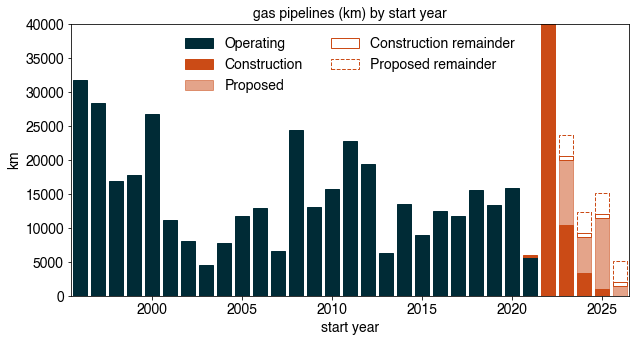

In [81]:
font_size = 14

fig = mp.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Operating'].values[1:],
       color=solar_base03, edgecolor=solar_base03, label='Operating')
ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Construction'].values[1:],
       color=solar_orange, edgecolor=solar_orange, bottom=past_future_sums_df['Operating'].replace(numpy.nan,0).values[1:], 
       label='Construction')
ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Proposed'].values[1:],
       color=solar_orange, edgecolor=solar_orange, alpha=0.5,
       bottom=past_future_sums_df[['Operating','Construction']].sum(axis=1).values[1:],
       label='Proposed')

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Construction Remainder'].values[1:],
       edgecolor=solar_orange, facecolor='None', alpha=1,
       bottom=past_future_sums_df[['Operating','Construction','Proposed']].sum(axis=1).values[1:],
       label='Construction remainder')

ax.bar(past_future_sums_df.index.values[1:], past_future_sums_df['Proposed Remainder'].values[1:],
       edgecolor=solar_orange, facecolor='None', alpha=1, linestyle='--',
       bottom=past_future_sums_df[['Operating','Construction','Proposed','Construction Remainder']].sum(axis=1).values[1:],
       label='Proposed remainder')

ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(1995.5, 2026.5)
ax.set_ylim(0, 40000)

ax.set_title('gas pipelines (km) by start year', size=font_size)

ax.legend(fontsize=font_size, frameon=False, loc='upper center', ncol=2)

## regions list, country list

In [82]:
regions_list = sorted(list(set(pipes_df['StartRegion'].dropna())))
country_list = sorted(list(set(country_ratios['Country'])))

## regional pipelines started in given year

In [83]:
years_array = numpy.arange( float(pipes_df['StartYearLatest'].min()), float(pipes_df['StartYearLatest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=regions_list)

In [84]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in regions_list:
    pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum

Text(48.0, 0.5, 'km')

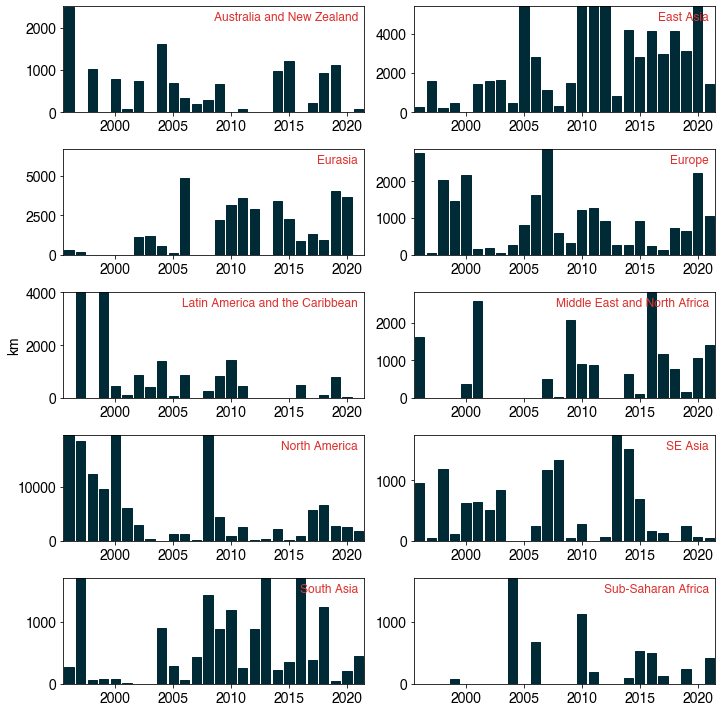

In [85]:
font_size = 14

fig = mp.figure(figsize=(10,10))#, constrained_layout=True)

ax_list = []

# plot the regional trends
for idx,region in enumerate(regions_list):
    ax = fig.add_subplot(5,2,idx+1)
    
    ax_list.append(ax)
    ax.bar(regions_startyear_sums_df.index.values[:-1], regions_startyear_sums_df[region].values[:-1],
           color=solar_base03, edgecolor=solar_base03)
    #ax.tick_params(labelsize=font_size)
    #ax.set_xlabel('start year', size=font_size)
    #ax.set_ylabel('km', size=font_size)

    ax.set_xlim(1995.5, 2021.5)
    ax.set_ylim(0, numpy.nanmean(regions_startyear_sums_df[region].values[:-1])*3)

    ax.text(x=0.98, y=0.95, s=region, transform=ax.transAxes, c=solar_red, size=12, ha='right', va='top')
    ax.tick_params(labelsize=font_size)

#ax.set_title('gas pipelines (km) by start year', size=font_size)
fig.tight_layout()

ax5 = ax_list[4]
ax5.set_ylabel('km', fontsize=font_size)

# calculate km by country, region

## plot regional Proposed and Construction bar plots

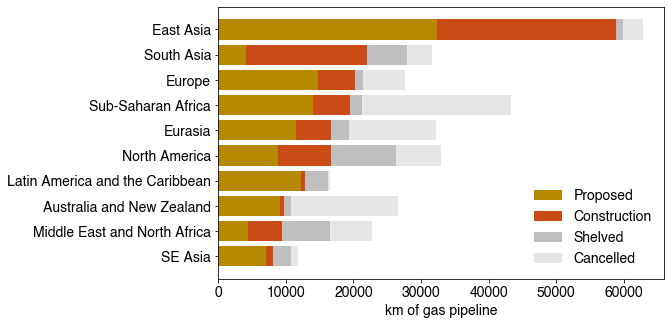

In [86]:
font_size = 14
fig = mp.figure(figsize=(8,5))

nbars = region_list.__len__()
region_order = km_by_region_df.index[:nbars][::-1]
ax = fig.add_subplot(111)
ax.barh(numpy.arange(nbars), 
        km_by_region_df.loc[region_order]['Proposed'].values, facecolor='#b58900', label='Proposed')
        
ax.barh(numpy.arange(nbars), 
        km_by_region_df.loc[region_order]['Construction'].values, 
        left=km_by_region_df.loc[region_order]['Proposed'].values, facecolor='#cb4b16', label='Construction')
        
ax.barh(numpy.arange(nbars), 
        km_by_region_df.loc[region_order]['Shelved'].values, 
        left=km_by_region_df.loc[region_order]['Proposed+Construction'].values, facecolor='0.75', label='Shelved')
        
ax.barh(numpy.arange(nbars), 
        km_by_region_df['Cancelled'].values, 
        left=km_by_region_df.loc[region_order][['Proposed','Construction','Shelved']].sum(axis=1).values, facecolor='0.9', label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_region_df.loc[region_order].index)
ax.tick_params(labelsize=font_size)

ax.set_xlabel('km of gas pipeline', size=font_size)

ax.legend(fontsize=font_size, frameon=False)

# Russia, India, China plots

In [87]:
pipes_started = pipes_df[(pipes_df['Status'].isin(['Operating'])) & (pipes_df['Fuel']=='Gas')]
pipes_started_sum_rus = pipes_started[pipes_started['Countries'].str.contains('Russia')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_chi = pipes_started[pipes_started['Countries'].str.contains('China')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_ind = pipes_started[pipes_started['Countries'].str.contains('India')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_usa = pipes_started[pipes_started['Countries'].str.contains('USA')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_aus = pipes_started[pipes_started['Countries'].str.contains('Australia')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_bra = pipes_started[pipes_started['Countries'].str.contains('Brazil')].groupby('StartYear1')['LengthMergedKm'].sum()


In [88]:
start_year = 1950
end_year = 2021
window_length = end_year-start_year+1

### China

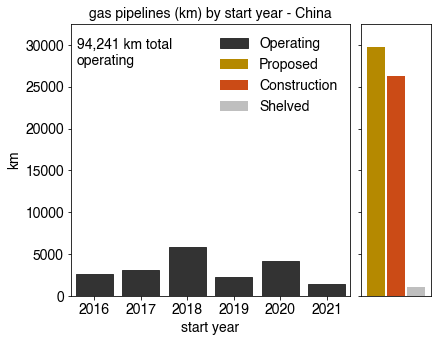

In [185]:
font_size = 14
ytop = 32500

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum_chi.index[:-1], pipes_started_sum_chi.values[:-1],
       color='0.2', edgecolor='0.2', label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.5, 2021.5)
ax.set_ylim(0, ytop)

#ax.axhline(pipes_started_sum_chi.sum()/window_length, zorder=0, ls='--', c=solar_base1)
ax.text(s="{:,.0f}".format(pipes_started_sum_chi.sum())+" km total\noperating", x=0.02, y=0.95, 
        ha='left', va='top', transform=ax.transAxes, fontsize=font_size)

ax.set_title('gas pipelines (km) by start year - China', size=font_size)
axpos = ax.get_position()
ax2 = fig.add_axes([axpos.x1+0.03, axpos.y0, 0.25*(axpos.x1-axpos.x0), axpos.y1-axpos.y0])
ax2.set_ylim(0, ytop)
ax2.set_xlim(0.25,3.75)

xvals = [1,2,3]
colors = [solar_yellow, solar_orange, '0.75']
status = ['Proposed','Construction', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc['China'][s],
             width=0.9, color=c, label=s))

ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

### India

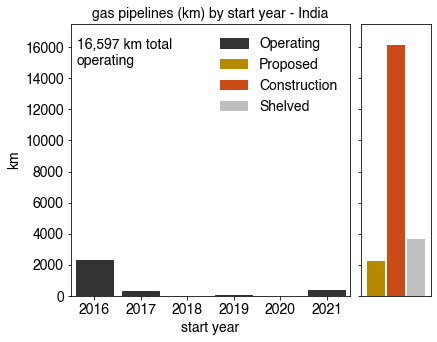

In [186]:
font_size = 14
ytop = 17500

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum_ind.index[:-1], pipes_started_sum_ind.values[:-1],
       color='0.2', edgecolor='0.2', label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.5, 2021.5)
ax.set_ylim(0, ytop)

#ax.axhline(pipes_started_sum_ind.sum()/window_length, zorder=0, ls='--', c=solar_base1)
ax.text(s="{:,.0f}".format(pipes_started_sum_ind.sum())+" km total\noperating", x=0.02, y=0.95, 
        ha='left', va='top', transform=ax.transAxes, fontsize=font_size)

ax.set_title('gas pipelines (km) by start year - India', size=font_size)
axpos = ax.get_position()
ax2 = fig.add_axes([axpos.x1+0.03, axpos.y0, 0.25*(axpos.x1-axpos.x0), axpos.y1-axpos.y0])
ax2.set_ylim(0, ytop)
ax2.set_xlim(0.25,3.75)

xvals = [1,2,3]
colors = [solar_yellow, solar_orange, '0.75']
status = ['Proposed','Construction', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc['India'][s],
             width=0.9, color=c, label=s))

ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

### USA

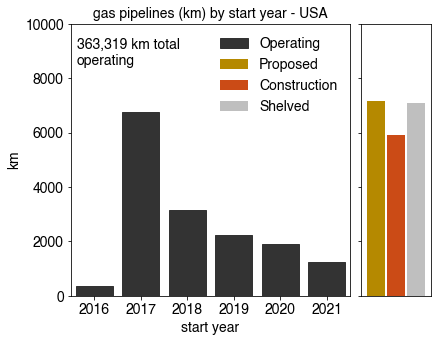

In [187]:
font_size = 14
ytop = 10000

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum_usa.index[:-1], pipes_started_sum_usa.values[:-1],
       color='0.2', edgecolor='0.2', label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.5, 2021.5)
ax.set_ylim(0, ytop)

#ax.axhline(pipes_started_sum_usa.sum()/window_length, zorder=0, ls='--', c=solar_base1)
ax.text(s="{:,.0f}".format(pipes_started_sum_usa.sum())+" km total\noperating", x=0.02, y=0.95, 
        ha='left', va='top', transform=ax.transAxes, fontsize=font_size)

ax.set_title('gas pipelines (km) by start year - USA', size=font_size)
axpos = ax.get_position()
ax2 = fig.add_axes([axpos.x1+0.03, axpos.y0, 0.25*(axpos.x1-axpos.x0), axpos.y1-axpos.y0])
ax2.set_ylim(0, ytop)
ax2.set_xlim(0.25,3.75)

xvals = [1,2,3]
colors = [solar_yellow, solar_orange, '0.75']
status = ['Proposed','Construction', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc['USA'][s],
             width=0.9, color=c, label=s))

ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

### Russia

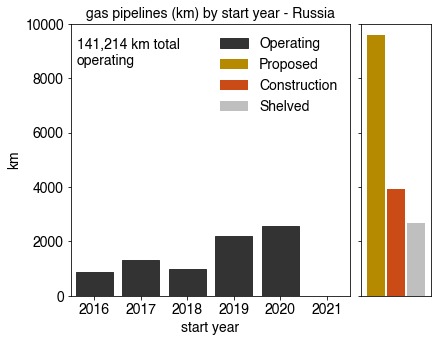

In [188]:
font_size = 14
ytop = 10000

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum_rus.index[:-1], pipes_started_sum_rus.values[:-1],
       color='0.2', edgecolor='0.2', label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.5, 2021.5)
ax.set_ylim(0, ytop)

#ax.axhline(pipes_started_sum_rus.sum()/window_length, zorder=0, ls='--', c=solar_base1)
ax.text(s="{:,.0f}".format(pipes_started_sum_rus.sum())+" km total\noperating", x=0.02, y=0.95, 
        ha='left', va='top', transform=ax.transAxes, fontsize=font_size)

ax.set_title('gas pipelines (km) by start year - Russia', size=font_size)
axpos = ax.get_position()
ax2 = fig.add_axes([axpos.x1+0.03, axpos.y0, 0.25*(axpos.x1-axpos.x0), axpos.y1-axpos.y0])
ax2.set_ylim(0, ytop)
ax2.set_xlim(0.25,3.75)

xvals = [1,2,3]
colors = [solar_yellow, solar_orange, '0.75']
status = ['Proposed','Construction', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc['Russia'][s],
             width=0.9, color=c, label=s))

ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

### Australia

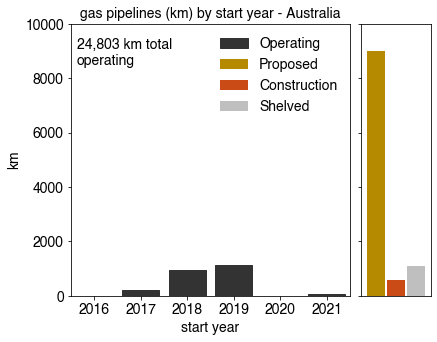

In [189]:
font_size = 14
ytop = 10000

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum_aus.index[:-1], pipes_started_sum_aus.values[:-1],
       color='0.2', edgecolor='0.2', label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.5, 2021.5)
ax.set_ylim(0, ytop)

#ax.axhline(pipes_started_sum_aus.sum()/window_length, zorder=0, ls='--', c=solar_base1)
ax.text(s="{:,.0f}".format(pipes_started_sum_aus.sum())+" km total\noperating", x=0.02, y=0.95, 
        ha='left', va='top', transform=ax.transAxes, fontsize=font_size)

ax.set_title('gas pipelines (km) by start year - Australia', size=font_size)
axpos = ax.get_position()
ax2 = fig.add_axes([axpos.x1+0.03, axpos.y0, 0.25*(axpos.x1-axpos.x0), axpos.y1-axpos.y0])
ax2.set_ylim(0, ytop)
ax2.set_xlim(0.25,3.75)

xvals = [1,2,3]
colors = [solar_yellow, solar_orange, '0.75']
status = ['Proposed','Construction', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc['Australia'][s],
             width=0.9, color=c, label=s))

ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

### Brazil

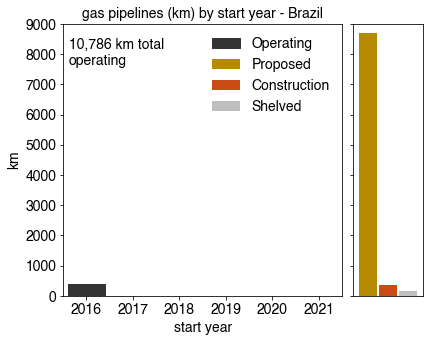

In [190]:
font_size = 14
ytop = 9000

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.bar(pipes_started_sum_bra.index[:-1], pipes_started_sum_bra.values[:-1],
       color='0.2', edgecolor='0.2', label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.5, 2021.5)
ax.set_ylim(0, ytop)

#ax.axhline(pipes_started_sum_bra.sum()/window_length, zorder=0, ls='--', c=solar_base1)
ax.text(s="{:,.0f}".format(pipes_started_sum_bra.sum())+" km total\noperating", x=0.02, y=0.95, 
        ha='left', va='top', transform=ax.transAxes, fontsize=font_size)

ax.set_title('gas pipelines (km) by start year - Brazil', size=font_size)
axpos = ax.get_position()
ax2 = fig.add_axes([axpos.x1+0.03, axpos.y0, 0.25*(axpos.x1-axpos.x0), axpos.y1-axpos.y0])
ax2.set_ylim(0, ytop)
ax2.set_xlim(0.25,3.75)

xvals = [1,2,3]
colors = [solar_yellow, solar_orange, '0.75']
status = ['Proposed','Construction', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc['Brazil'][s],
             width=0.9, color=c, label=s))

ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

# top 20 countries proposed+construction

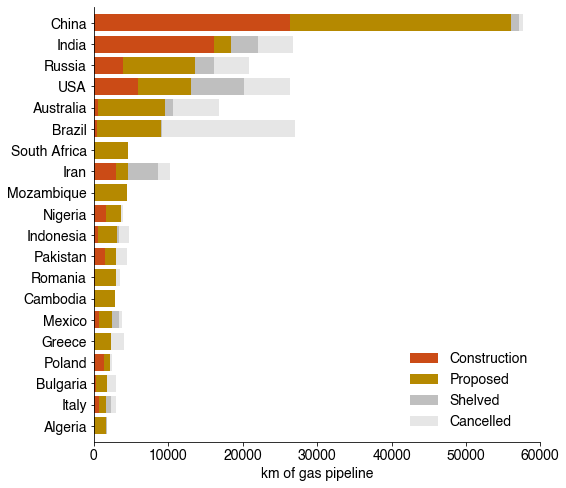

In [169]:
font_size = 14
fig = mp.figure(figsize=(8,8))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor='0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor='0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.set_xlim(0,60000)
ax.set_ylim(-.75,19.75)
ax.set_xlabel('km of gas pipeline', size=font_size)

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_top-20-countries.pdf', bbox_inches='tight', transparent=True)


In [96]:
# ratio of China to India
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

3.0518165539120448

# cost estimates (pipeline cost per km)

## looking for cost outliers

In [97]:
outliers_projectids = ['P2509','P0173','P1297','P0174','P3188','P2551']

In [98]:
#pipes_cost_outliers_df = pipes_df[(pipes_df['Fuel']=='Gas') & (pipes_df['Countries'].str.contains('India'))]
pipes_cost_outliers_df = pipes_df[(pipes_df['Fuel']=='Gas')]
pipes_cost_outliers_df = pipes_cost_outliers_df[~pipes_cost_outliers_df.ProjectID.isin(outliers_projectids)]

## global costs - remove outliers

In [99]:
# pull out only pipelines that have a KNOWN length AND a cost
pipes_gas_length_cost_df = pipes_df[(pipes_df['Fuel']=='Gas') & 
                                    (pipes_df['LengthKnownKm'].notna()) & 
                                    (pipes_df['CostMergedUSD'].notna()) 
                                   ]
pipes_gas_length_cost_df = pipes_gas_length_cost_df[~pipes_gas_length_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [100]:
pipes_gas_length_cost_df['CostMergedUSD'].mean()/pipes_gas_length_cost_df['LengthKnownKm'].mean()

2980277.205379136

In [101]:
pipes_gas_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for region in region_list:
    print(region)
    region_subset = pipes_gas_length_cost_df[pipes_gas_length_cost_df['StartRegion']==region]
    pipes_gas_costs_region_df.loc[region]['CostUSDPerKm'] = region_subset['CostMergedUSD'].mean()/region_subset['LengthKnownKm'].mean()
    pipes_gas_costs_region_df.loc[region]['NumberOfCosts'] = region_subset[~region_subset['CostMergedUSD'].isnull()]['CostMergedUSD'].count()
    pipes_gas_costs_region_df.loc[region]['NumberOfLengths'] = region_subset[~region_subset['LengthKnownKm'].isnull()]['LengthKnownKm'].count()
    

Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


## regional cost breakdown

In [102]:
pipes_gas_costs_region_df

,CostUSDPerKm,NumberOfCosts,NumberOfLengths
Australia and New Zealand,1310330,10,10
East Asia,1305235,59,59
Eurasia,4321143,17,17
Europe,2865836,75,75
Latin America and the Caribbean,1649314,24,24
Middle East and North Africa,2632225,11,11
North America,5047659,158,158
SE Asia,1728994,8,8
South Asia,882338,17,17
Sub-Saharan Africa,3601625,6,6


## for India, USA, China, Indonesia

In [103]:
print("India")
country_subset = pipes_gas_length_cost_df[pipes_gas_length_cost_df['Countries'].str.contains('India')]
print(country_subset['CostMergedUSD'].mean()/country_subset['LengthKnownKm'].mean())
print("Indonesia")
country_subset = pipes_gas_length_cost_df[pipes_gas_length_cost_df['Countries'].str.contains('Indonesia')]
print(country_subset['CostMergedUSD'].mean()/country_subset['LengthKnownKm'].mean())
print("China")
country_subset = pipes_gas_length_cost_df[pipes_gas_length_cost_df['Countries'].str.contains('China')]
print(country_subset['CostMergedUSD'].mean()/country_subset['LengthKnownKm'].mean())
print("USA")
country_subset = pipes_gas_length_cost_df[pipes_gas_length_cost_df['Countries'].str.contains('USA')]
print(country_subset['CostMergedUSD'].mean()/country_subset['LengthKnownKm'].mean())

India
722174.6637899941
Indonesia
835137.5332741791
China
1293421.710564462
USA
4863572.775730859


## stranded asset calculations

In [104]:
pandas.options.display.float_format = '{:,.2f}'.format
#km_by_region_df.sort_index(inplace=True)
#indices_without_total = list(km_by_region_df.index)
#if 'Total' in indices_without_total:
#    indices_without_total.remove('Total')

capex_estimates_df = km_by_region_df.loc[region_list].multiply(pipes_gas_costs_region_df['CostUSDPerKm'].values, axis=0) / 1e9

total = capex_estimates_df.sum(axis=0)
total.name='Total'
capex_estimates_df = capex_estimates_df.append(total)

capex_estimates_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Australia and New Zealand,12.00,0.76,12.76,1.44,8.07,35.79,0.00,0.00,0.00
East Asia,42.32,34.39,76.71,1.36,1.36,120.28,0.00,0.00,0.05
Eurasia,50.06,21.99,72.04,11.55,28.71,603.98,0.00,0.83,11.03
Europe,42.38,15.44,57.82,3.65,45.30,333.90,0.00,0.00,3.09
Latin America and the Caribbean,20.18,0.89,21.07,5.70,36.55,71.46,0.00,0.37,0.00
Middle East and North Africa,11.56,13.20,24.75,18.90,9.75,77.86,3.16,0.00,0.10
North America,45.00,38.90,83.90,48.51,65.00,"2,111.31",2.60,0.00,0.00
SE Asia,12.20,1.94,14.14,4.55,5.21,27.39,0.00,0.00,0.00
South Asia,3.61,15.76,19.37,5.31,5.42,18.16,0.00,0.00,0.03
Sub-Saharan Africa,50.60,19.87,70.47,5.88,1.04,42.33,0.00,0.00,0.00


## pie chart for stranded assets

In [113]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)[1:]

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,45.00,38.90,83.90,48.51,65.00,"2,111.31",2.60,0.00,0.00
East Asia,42.32,34.39,76.71,1.36,1.36,120.28,0.00,0.00,0.05
Eurasia,50.06,21.99,72.04,11.55,28.71,603.98,0.00,0.83,11.03
Sub-Saharan Africa,50.60,19.87,70.47,5.88,1.04,42.33,0.00,0.00,0.00
Europe,42.38,15.44,57.82,3.65,45.30,333.90,0.00,0.00,3.09
Middle East and North Africa,11.56,13.20,24.75,18.90,9.75,77.86,3.16,0.00,0.10
Latin America and the Caribbean,20.18,0.89,21.07,5.70,36.55,71.46,0.00,0.37,0.00
South Asia,3.61,15.76,19.37,5.31,5.42,18.16,0.00,0.00,0.03
SE Asia,12.20,1.94,14.14,4.55,5.21,27.39,0.00,0.00,0.00
Australia and New Zealand,12.00,0.76,12.76,1.44,8.07,35.79,0.00,0.00,0.00


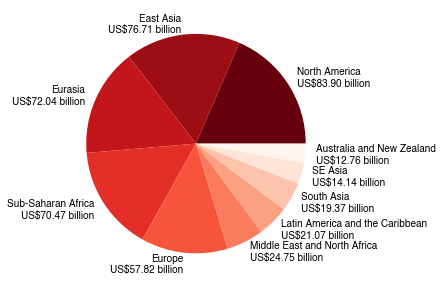

In [168]:
font_size=14

fig = mp.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cmap = mp.get_cmap('Reds')

pie_vals = capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'][1:]
pie_labels = capex_estimates_df.sort_values('Proposed+Construction', ascending=False).index[1:]
pie_labels_dollars = capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].apply(lambda x: f'\nUS${x:.2f} billion')[1:]

pie_labels = [i+j for i,j in zip(pie_labels, pie_labels_dollars)]

ax.pie(pie_vals, 
       labels=pie_labels,
       colors=cmap(numpy.linspace(0,1,pie_vals.size))[::-1] )

ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_pie-graph.pdf', bbox_inches='tight', transparent=True)


In [140]:
pie_vals

North America                     83.90
East Asia                         76.71
Eurasia                           72.04
Sub-Saharan Africa                70.47
Europe                            57.82
Middle East and North Africa      24.75
Latin America and the Caribbean   21.07
South Asia                        19.37
SE Asia                           14.14
Australia and New Zealand         12.76
Name: Proposed+Construction, dtype: float64

In [154]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].apply(lambda x: f'US${x:.2f} billion')[1:]

North America                      US$83.90 b.
East Asia                          US$76.71 b.
Eurasia                            US$72.04 b.
Sub-Saharan Africa                 US$70.47 b.
Europe                             US$57.82 b.
Middle East and North Africa       US$24.75 b.
Latin America and the Caribbean    US$21.07 b.
South Asia                         US$19.37 b.
SE Asia                            US$14.14 b.
Australia and New Zealand          US$12.76 b.
Name: Proposed+Construction, dtype: object

In [142]:
pie_vals['Proposed+Construction'].apply(lambda x: f'{x:2d}')

KeyError: 'Proposed+Construction'

In [125]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'][1:]

North America                     83.90
East Asia                         76.71
Eurasia                           72.04
Sub-Saharan Africa                70.47
Europe                            57.82
Middle East and North Africa      24.75
Latin America and the Caribbean   21.07
South Asia                        19.37
SE Asia                           14.14
Australia and New Zealand         12.76
Name: Proposed+Construction, dtype: float64

In [124]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False).index[1:]

Index(['North America', 'East Asia', 'Eurasia', 'Sub-Saharan Africa', 'Europe',
       'Middle East and North Africa', 'Latin America and the Caribbean',
       'South Asia', 'SE Asia', 'Australia and New Zealand'],
      dtype='object')

In [120]:
region_list.__len__()

10

In [118]:
cmap = mp.get_cmap('magma')

#print('Default number of colors in the lookup table:', len(cmap.colors)) # default: 256 colors
#print('First color:', cmap.colors[0])
#print('Last color:', cmap.colors[-1])
#print('10 equally spaced colors:', cmap(np.linspace(0, 1, 10)))

### amount already being constructed

In [ ]:
#km
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

In [ ]:
total['Construction']/total['Proposed+Construction']

## ownership research

# numbers for report

In [ ]:
# km of gas pipelines globally in development
pipes_df_calc = pipes_df.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

In [ ]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
regional_km_sums_df.append(total_row)

In [ ]:
pipes_df_calc[pipes_df_calc['Fuel']=='Gas']['LengthMergedKm'].sum()

## country shares analysis

In [ ]:
country_ratios[(country_ratios['Status'].isin(['Proposed','Construction'])) &
               (country_ratios['Fuel']=='Gas')]['MergedKmByCountry'].sum()

### China's percent of total

In [ ]:
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df['Proposed+Construction'].sum(axis=0)

In [ ]:
km_by_country_df[:6]['Proposed+Construction'].sum(axis=0)/km_by_country_df['Proposed+Construction'].sum(axis=0)

In [ ]:
km_by_country_df[:20]['Proposed+Construction'].sum(axis=0)/km_by_country_df['Proposed+Construction'].sum(axis=0)

## number of delayed km from 2021 to 2022

In [ ]:
pipes_delays_df = pipes_df.copy()
pipes_delays_df = pipes_delays_df[(pipes_delays_df['Fuel']=='Gas') &
                                  (pipes_delays_df['Delayed']=='Yes') &
                                   (pipes_delays_df['StartYearLatest']==2022)]

pipes_delays_df.groupby('Status')['LengthMergedKm'].sum()

In [ ]:
pipes_delays_df = pipes_df.copy()
pipes_delays_df = pipes_delays_df[(pipes_delays_df['Fuel']=='Gas') &
                                  (pipes_delays_df['Delayed']=='Yes') &
                                   (pipes_delays_df['StartYearLatest']==2022) &
                                   (pipes_delays_df['DelayType']=='Presumed')]

pipes_delays_df.groupby('Status')['LengthMergedKm'].sum()